In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import json
import torch
import sys
sys.path.append('../')
from cxr_fairness.data import data
from cxr_fairness.data import Constants
import matplotlib.pyplot as plt
from scipy.special import logit, expit
from cxr_fairness.plot_utils import *
from cxr_fairness.data import process
from cxr_fairness.metrics import StandardEvaluator
import matplotlib.lines as mlines
import matplotlib
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
from pathlib import Path
import matplotlib.lines as mlines
from collections import defaultdict

fig_dir = Path('/scratch/ssd001/home/haoran/projects/CXR_Fairness/notebooks/cxr_debias_figures')
fig_dir.mkdir(exist_ok = True)

class smart_dict(dict):
    def __missing__(self, key):
        return key

grp_name_mapping = smart_dict({
    'F': "Female",
    'M': 'Male',
    0: 'White',
    1: 'Black',
    2: "Other"
})

orders = {
    'sex': ['M', 'F'],
    'ethnicity': [0, 1, 2],
    'age': ['18-40', '40-60', '60-80', '80-']    
}

def select_best(d):
    return d.loc[d.worst_roc.idxmax(), 'config_filename']

task= 'no_finding'

In [2]:
# bootstrap results
df = pd.concat((pd.read_pickle(f'/h/haoran/sto/cxr_debias_boot/MIMIC_densenet_{task}_vary_lambda_exp_MMD_boot.pkl'),
                pd.read_pickle(f'/h/haoran/sto/cxr_debias_boot/MIMIC_densenet_{task}_vary_lambda_exp_mean_match_boot.pkl'),
                pd.read_pickle(f'/h/haoran/sto/cxr_debias_boot/MIMIC_densenet_{task}_vary_lambda_exp_simple_adv_boot.pkl')))

In [3]:
df['method'] = df.exp_name.apply(lambda x: x[:x.rfind('_')])
df['lambda'] = df.exp_name.apply(lambda x: float(x[x.rfind('_')+1:]))

In [4]:
def map_metric(x):
    if x.startswith(('recall', 'specificity', 'precision', 'calibration_diff')) and not x.endswith(('min', 'max')):
        val = float(x.split('_')[-1])
        return x[0].upper() + '_'.join(x.split('_')[:-1])[1:] + ' @ ' + x.split('_')[-1]
    other_mapping = {
        'auc': 'AUROC',
        'auprc': 'AUPRC',
        'ace_abs_logistic_log': 'ACE',
        'loss_bce': 'BCE',
        'ece_abs': 'ECE',
        'mean_prediction_1': 'Mean Prediction (Y=1)',
        'mean_prediction_0': 'Mean Prediction (Y=0)'
    }
    return x if x not in other_mapping else other_mapping[x]

In [5]:
df.method = df.method.map(
    {
        'MMD': 'MMDMatch', 
        'mean_match': 'MeanMatch',
        'simple_adv': 'Adversarial'
    }
)

df['metric'] = df['metric'].map(map_metric)

In [6]:
df.loc[df.metric == 'sens_at_spec_0.8', 'metric'] = 'TPR @ 80% TNR'
df.loc[df.metric == 'sens_at_spec_0.5', 'metric'] = 'TPR @ 50% TNR'

In [7]:
metrics = ['AUROC', 
                                  #       'AUPRC',  
                                 #        'ACE', 
                                        'BCE',
        'ECE', 
        'TPR @ 80% TNR',
#         'TPR @ 50% TNR',
      #  'calibration_diff_0.5',
        'Recall @ 0.5',
        'Specificity @ 0.5',
#          'Recall @ 0.25',
#           'Specificity @ 0.25',
#        'Recall @ Opt',
#        'Specificity @ Opt',        
           'Mean Prediction (Y=0)',
           'Mean Prediction (Y=1)'
       ]

methods = ['MMDMatch', 'MeanMatch', 'Adversarial']

In [8]:
eval_group = 'ethnicity'
df= df[df.eval_group == eval_group]

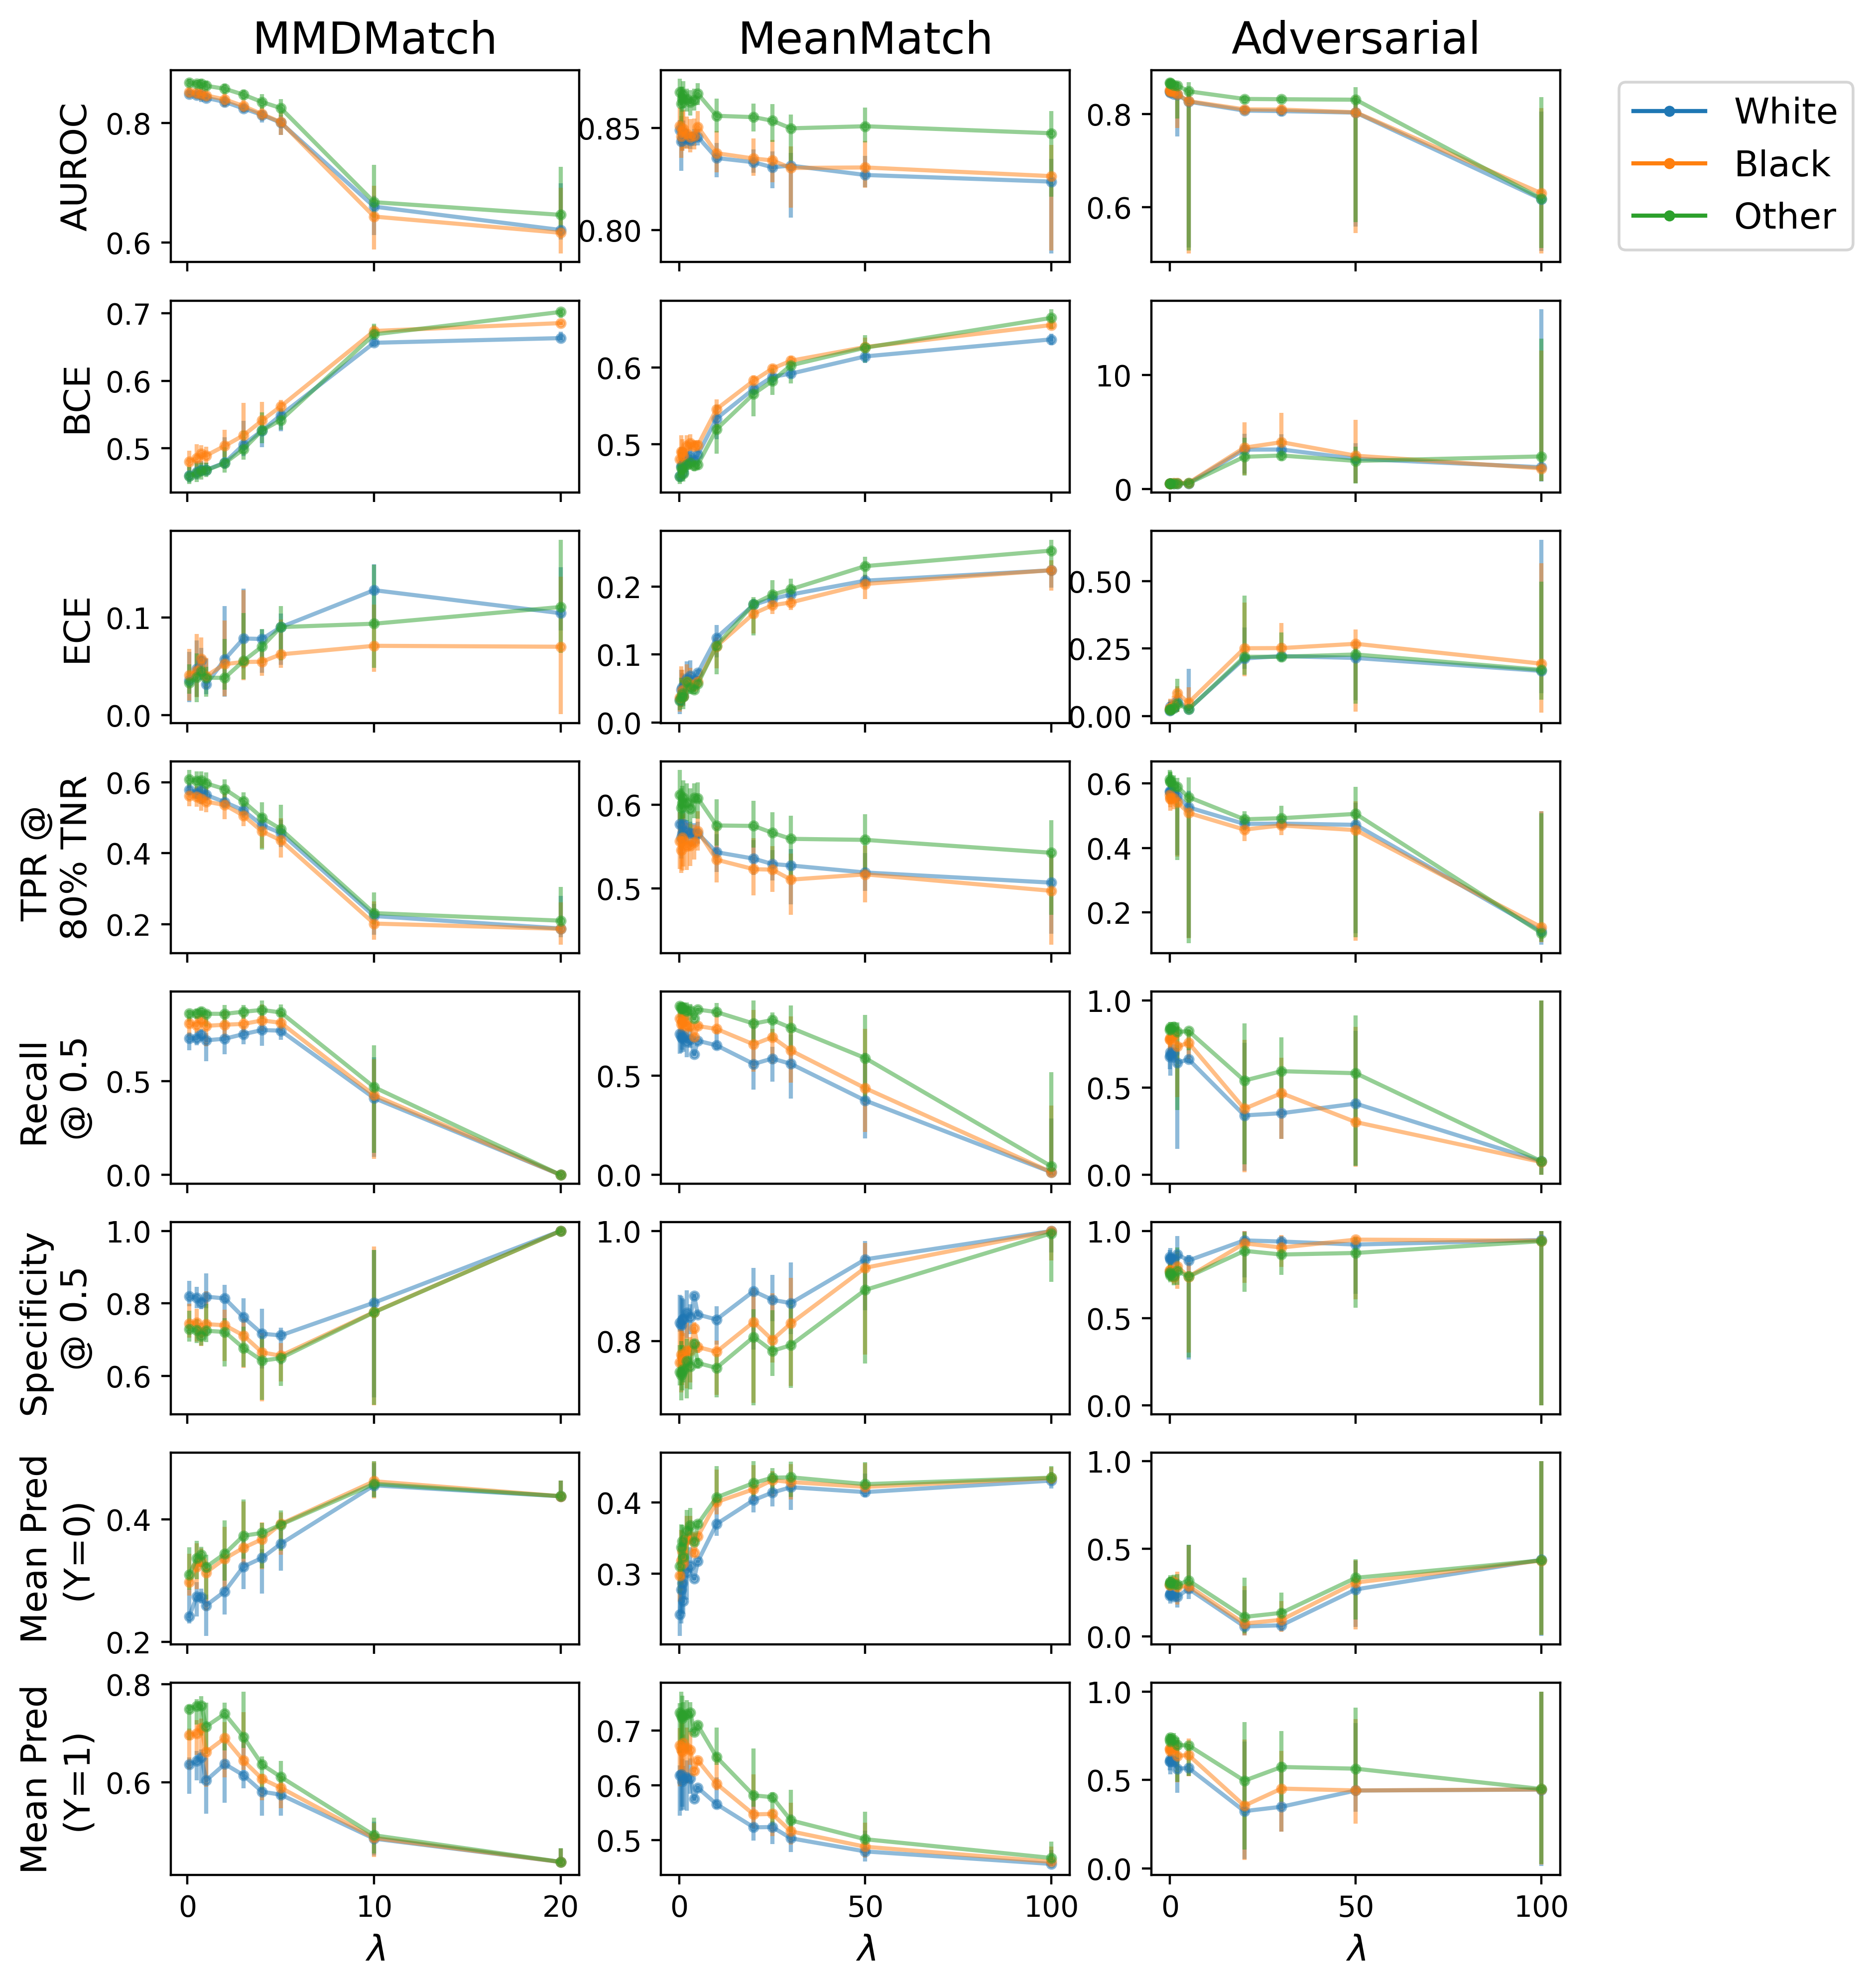

In [11]:
display_mapping = smart_dict({
    'Mean Prediction (Y=1)' : 'Mean Pred\n(Y=1)',
    'Mean Prediction (Y=0)' : 'Mean Pred\n(Y=0)',
    'Specificity @ 0.5': 'Specificity \n@ 0.5',
    'Recall @ 0.5': 'Recall \n@ 0.5',
    'TPR @ 80% TNR': 'TPR @ \n80% TNR'
})

display_offsets = defaultdict(lambda: -0.3, {
    # 'Recall @ 0.5': -0.4
})

plt.rcParams['font.size'] = '13'
plt.rc('ytick', labelsize = 10.5)
plt.rc('xtick', labelsize = 10.5)

fig, axs = plt.subplots(nrows = len(metrics), ncols = len(methods), figsize = (3*len(methods), 1.5 * len(metrics)), 
                        sharex = 'col', sharey = False, dpi = 400)

colors = ['C0', 'C1', 'C2']
for c, method in enumerate(methods):
    for d, metric in enumerate(metrics):
        ax = axs[d][c]
        subset = df[(df.method == method) & (df.metric == metric) & (df.grp_val != 'overall')]
        if method == "MMDMatch":
            subset = subset[subset['lambda'] <= 20]
        elif method == 'MeanMatch':
            subset = subset[subset['lambda'] <= 100]
        else:
            subset = subset[subset['lambda'] <= 200]
            
        for e, grp in enumerate(np.sort(subset.grp_val.unique())):
            subset2 = subset[subset.grp_val == grp].sort_values(by = 'lambda')
            
            ax.errorbar(y = subset2['CI_med'].values, x = subset2['lambda'].values, fmt = '.-', 
                            yerr = np.abs(subset2[['CI_lower', 'CI_upper']].values - np.expand_dims(subset2['CI_med'].values, axis = -1)).T, 
                        color = colors[e], alpha = 0.5)
            
        if c == 0:
            ax.set_ylabel(display_mapping[metric])
        #elif c == len(methods) - 1:
                    
        if d == 0:
            ax.set_title(method, fontsize = 16)
        elif d == len(metrics) - 1:
            ax.set_xlabel('$\lambda$')
                       
            
legend = [
        mlines.Line2D([], [], linestyle = '-', color = colors[e], marker ='.',
                     label = grp_name_mapping[grp]) for e, grp in enumerate(np.sort(subset.grp_val.unique()))
    ]

leg1 = axs[0][-1].legend(handles = legend, loc='center left', bbox_to_anchor=(1.1,0.5))  
# fig.tight_layout()
fig.savefig(fig_dir/('compr_adv_metrics_transposed.pdf'), dpi = 400, bbox_inches = 'tight')
fig.align_ylabels(axs[:, 0])
# plt.tight_layout()
plt.show()